# Assignment 2: Next Streamer Prediction on Twitch

#### By: Ryan Cao, Ketan Mittal, Anirudh Annabathula

We model Twitch's LiveRec dataset to predict the next streamer a user will watch, using sequential recommender baselines (global popularity) and the Factorized Personalized Markov Chain (FPMC) models covered in class.

---

## Table of Contents

1. [Predictive Task, Evaluation, and Validity](#section1)
2. [Exploratory Analysis and Preprocessing](#section2)
3. [Modeling](#section3)
4. [Evaluation](#section4)
5. [Related Work](#section5)

> Supporting runtime/setup cells run first so every section can execute from a clean kernel.


In [1]:
import sys, platform
print("Python:", sys.executable)
print("Version:", platform.python_version())

Python: c:\Users\Ryan_pc\miniforge3\envs\dsc80\python.exe
Version: 3.12.7


In [2]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install",
                          "torch", "torchvision", "torchaudio",
                          "--index-url", "https://download.pytorch.org/whl/cu118"])

0

### Supporting Runtime Setup
- Print the active interpreter so reproducibility is documented.
- Install the CUDA-enabled PyTorch stack that we use in Section 3.
- Set `KMP_DUPLICATE_LIB_OK` to avoid the OpenMP conflict between PyTorch and SciPy on Windows.
- Import every dependency, configure GPU/CPU fallbacks, enforce seeds, and confirm the dataset path before Section 1 begins.
Run these cells once per session, then proceed to the rubric-driven sections.

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
# Imports and Setup
import os
import gzip
import csv
import random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Optional GPU acceleration 
STREAMER_BACKEND = os.environ.get("STREAMER_BACKEND", "auto").lower()
GPU_ENABLED = False
GPU_STATUS = "CPU mode"
cp = None
cudf = None

try:
    if STREAMER_BACKEND != "cpu":
        import cupy as cp
        import cudf

        if cp.cuda.runtime.getDeviceCount() > 0:
            GPU_ENABLED = True
            gpu_device = cp.cuda.Device(0)
            GPU_STATUS = f"GPU mode: {gpu_device.name}" if hasattr(gpu_device, "name") else "GPU mode"
        else:
            GPU_STATUS = "No CUDA devices detected - defaulting to CPU"
            STREAMER_BACKEND = "cpu"
    else:
        GPU_STATUS = "CPU mode requested via STREAMER_BACKEND"
except Exception as gpu_exc:
    GPU_ENABLED = False
    STREAMER_BACKEND = "cpu"
    GPU_STATUS = f"GPU unavailable ({gpu_exc})"
    cp = None
    cudf = None

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
if GPU_ENABLED and cp is not None:
    cp.random.seed(42)

TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if TORCH_DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(42)


def to_pandas_cpu(obj):
    """Move cudf objects to host pandas for downstream CPU ops."""
    if GPU_ENABLED and hasattr(obj, "to_pandas"):
        return obj.to_pandas()
    return obj


def to_numpy_cpu(obj):
    """Convert device arrays/Series to numpy on the CPU."""
    if GPU_ENABLED and cp is not None and isinstance(obj, cp.ndarray):
        return cp.asnumpy(obj)
    obj = to_pandas_cpu(obj)
    if hasattr(obj, "to_numpy"):
        return obj.to_numpy()
    return np.asarray(obj)


print(GPU_STATUS)
print(f"PyTorch device: {TORCH_DEVICE}")

# Configuration
# Ensure we're in the assignment2 directory (where the data files are)
if os.path.basename(os.getcwd()) != 'assignment2':
    if os.path.exists('assignment2'):
        os.chdir('assignment2')
        print(f"Changed to assignment2 directory: {os.getcwd()}")

DATASET_PATH = './100k.csv'  # Use 100k.csv for development
# DATASET_PATH = 'full_a.csv.gz'  # Use full dataset for final results
MIN_INTERACTIONS = 2  # Minimum interactions per user for sequence prediction

# Verify file exists
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    print(f"Dataset file found: {DATASET_PATH}")


c:\Users\Ryan_pc\miniforge3\envs\dsc80\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


GPU unavailable (No module named 'cudf')
PyTorch device: cuda
Dataset file found: ./100k.csv


> **GPU/CPU switching**: Set the `STREAMER_BACKEND` environment variable to `gpu` (default: `auto`) before starting the notebook to prefer GPU execution. Use `STREAMER_BACKEND=cpu` to force CPU mode. The code automatically falls back to CPU if CUDA or RAPIDS are unavailable.


In [5]:
def load_data(filepath):
    """Load Twitch dataset from CSV file with optional GPU acceleration."""
    cols = ["user", "stream", "streamer", "start", "stop"]

    if GPU_ENABLED and cudf is not None:
        if filepath.endswith('.gz'):
            df_cpu = pd.read_csv(filepath, header=None, names=cols, compression='gzip')
            df = cudf.from_pandas(df_cpu)
        else:
            df = cudf.read_csv(filepath, header=None, names=cols)
    else:
        df = pd.read_csv(filepath, header=None, names=cols, compression='gzip' if filepath.endswith('.gz') else None)

    return df


# 1. Issue <a id="section1"></a>

### 1.1 Predictive Task

We predict the single next streamer a user will watch given their most recent history. Inputs consist of the user ID plus their last observed streamer; output is one recommended streamer (the argmax). We study two levels of sophistication: (1) a POP baseline that always recommends the globally most-watched streamer, and (2) FPMC-based models that combine user preference, first-order transitions, and optional “buzz/shock/switch” biases tailored to Twitch’s fast-moving browsing patterns.

### 1.2 Evaluation Metrics

Because we emit exactly one candidate per user, we evaluate using top-1, top-5, and top-10 accuracy/precision/recall/F1. Every model is trained on 95% of the 100k subset and evaluated on the most recent 2.5% + 2.5% slices; we also subsample 3–5k rows so evaluation remains lightweight. Due to Memory, CPU, and GPU constraints we only test 2.5% to prevent large runtimes.

### 1.3 Baseline Models

- **POP**: Always recommend the globally most popular streamer; sanity check for any sequential model.
- **FPMC**: Factorized Personalized Markov Chains capturing `⟨U_u,V_j⟩ + ⟨P_i,Q_j⟩` (user preference + transition). We include a plain version and feature-augmented variants (buzz, shock index, switching rate) plus a few tuned settings for hyperparameter sweeps.

### 1.4 Model Validity Assessment

- **Temporal splits**: chronological 95/2.5/2.5 on `100k.csv` to mimic “train on almost everything, validate/test on the newest sliver,” then the exact pipeline scales to a 98/1/1 split on the full dump. We do not use the 15 million rows dataset because we do not have the memory nor gpu to tran with it.
- **ID encoding**: user/streamer mappings are fit on the training slice only; unseen IDs in val/test are dropped to avoid leakage.
- **Evaluation sampling**: fixed-size samples (3k–5k) keep validation/test fast but large enough to compare models.
- **Notebook/presentation alignment**: each section walks through the corresponding code so peer graders can follow the same pipeline end-to-end before we run the final full-scale experiment.


## 2. EXPLORATORY ANALYSIS, DATA COLLECTION, AND PREPROCESSING <a id="section2"></a>

### 2.1 Dataset Context and Collection

**Source**: The Twitch dataset comes from the [LiveRec repository](https://github.com/JRappaz/liverec) (Rappaz et al., RecSys 2021). This dataset was created to study recommendation challenges specific to live-streaming platforms.

**Collection Method**: The data was collected by taking snapshots of all available streams on Twitch every 10 minutes over a 43-day period. For each stream, the researchers retrieved all logged-in users from the chat. All usernames have been anonymized for privacy.

**Purpose**: This dataset was designed to study:
- **Dynamic availability**: Unlike traditional recommendation (e.g., movies, books), streamers are only available when they're live
- **Repeat consumption**: Users frequently return to the same streamers, but the content is ephemeral
- **Temporal patterns**: Viewing behavior changes over time as streamers go on/offline

**Dataset Structure**:
- Each row represents a user-streamer interaction
- Fields: `user_id`, `stream_id`, `streamer_name`, `start_time`, `stop_time`
- Time is measured in 10-minute intervals (timesteps)
- `start_time`: First crawling round when user was seen in chat
- `stop_time`: Last crawling round when user was seen in chat

**Available Files**:
- `full_a.csv.gz`: Full dataset (15.5M users, 465k streamers, 124M interactions)
- `100k.csv`: Subset for benchmarking (100k users, 162.6k streamers, 3M interactions)

We use the 100k subset for development and analysis, as it's more manageable while still being representative.


In [6]:
# Load raw data
data_raw = load_data(DATASET_PATH)
print(f"Loaded dataset: {len(data_raw):,} interactions, {data_raw['user'].nunique():,} users, {data_raw['streamer'].nunique():,} streamers")


Loaded dataset: 3,051,733 interactions, 100,000 users, 162,625 streamers


In [7]:
# Load raw data
data_raw = load_data(DATASET_PATH)


### 2.3 Data Validation and Cleaning
The next code cell defines `validate_data_quality`, which applies the following checks before we build sequences:
1. Drop rows where `stop < start` (impossible viewing windows).
2. Remove blank/whitespace streamer names.
3. Deduplicate `(user, streamer, start)` triples that appear multiple times because of crawler jitter.
The helper returns a cleaned DataFrame plus a summary dictionary that the following cell prints.


In [8]:
def validate_data_quality(df):
    """Validate data quality and return cleaned DataFrame with statistics."""
    initial_count = len(df)
    
    # Check for data quality issues
    invalid_count = (df['stop'] < df['start']).sum()
    empty_count = (df['streamer'].isna() | (df['streamer'].str.strip() == '')).sum()
    duplicates_count = df.duplicated(subset=['user', 'streamer', 'start']).sum()
    
    # Clean if needed
    df_clean = df.copy()
    if invalid_count > 0:
        df_clean = df_clean[df_clean['stop'] >= df_clean['start']].copy()
    if empty_count > 0:
        df_clean = df_clean[~df_clean['streamer'].isna()].copy()
        df_clean['streamer'] = df_clean['streamer'].str.strip()
    if duplicates_count > 0:
        df_clean = df_clean.drop_duplicates(subset=['user', 'streamer', 'start']).copy()
    
    stats = {
        'initial_count': initial_count,
        'final_count': len(df_clean),
        'invalid_time': invalid_count,
        'empty_streamer': empty_count,
        'duplicates': duplicates_count,
        'removed': initial_count - len(df_clean)
    }
    
    return df_clean, stats
data_clean, validation_stats = validate_data_quality(data_raw)

In [9]:
# Validation Results Summary
print("Validation Results:")
print(f"  Invalid time ranges: {validation_stats['invalid_time']:,}")
print(f"  Empty streamer names: {validation_stats['empty_streamer']:,}")
print(f"  Duplicates: {validation_stats['duplicates']:,}")
print(f"  Data removed: {validation_stats['removed']:,} ({100*validation_stats['removed']/validation_stats['initial_count']:.2f}%)")
print("\n✓ Dataset is clean - proceeding to outlier analysis")





Validation Results:
  Invalid time ranges: 0
  Empty streamer names: 0
  Duplicates: 0
  Data removed: 0 (0.00%)

✓ Dataset is clean - proceeding to outlier analysis


### 2.4 Outlier Analysis (Summary Statistics)
The upcoming code derives watch durations, user interaction counts, streamer popularity, and per-round activity, then applies the IQR rule to quantify how many observations fall beyond the upper whisker before we visualize them.


In [10]:
# Outlier Detection: Calculate statistics and identify outliers using IQR method

# Prepare data
data_clean['duration'] = data_clean['stop'] - data_clean['start'] + 1
watch_durations = to_numpy_cpu(data_clean['duration'])
user_counts = data_clean['user'].value_counts()
user_interaction_counts = to_numpy_cpu(user_counts)
streamer_counts = data_clean['streamer'].value_counts()
streamer_popularity = to_numpy_cpu(streamer_counts)
interactions_by_time = to_numpy_cpu(data_clean.groupby('start').size())

# Watch Duration Outliers
duration_q1, duration_median, duration_q3 = np.percentile(watch_durations, [25, 50, 75])
duration_iqr = duration_q3 - duration_q1
duration_upper = duration_q3 + 1.5 * duration_iqr
duration_outliers = int((watch_durations > duration_upper).sum())

# User Activity Outliers
user_q1, user_median, user_q3 = np.percentile(user_interaction_counts, [25, 50, 75])
user_iqr = user_q3 - user_q1
user_upper = user_q3 + 1.5 * user_iqr
user_outliers = int((user_interaction_counts > user_upper).sum())

# Streamer Popularity Outliers
streamer_q1, streamer_median, streamer_q3 = np.percentile(streamer_popularity, [25, 50, 75])
streamer_iqr = streamer_q3 - streamer_q1
streamer_upper = streamer_q3 + 1.5 * streamer_iqr
streamer_outliers = int((streamer_popularity > streamer_upper).sum())

# Temporal Outliers
temporal_q1, temporal_median, temporal_q3 = np.percentile(interactions_by_time, [25, 50, 75])
temporal_iqr = temporal_q3 - temporal_q1
temporal_upper = temporal_q3 + 1.5 * temporal_iqr
temporal_outliers = int((interactions_by_time > temporal_upper).sum())

# Print summary
print("Outlier Detection Summary (IQR method):")
print(f"  Watch duration: {duration_outliers:,} outliers ({100*duration_outliers/len(watch_durations):.2f}%)")
print(f"  User activity: {user_outliers:,} outliers ({100*user_outliers/len(user_interaction_counts):.2f}%)")
print(f"  Streamer popularity: {streamer_outliers:,} outliers ({100*streamer_outliers/len(streamer_popularity):.2f}%)")
print(f"  Temporal activity: {temporal_outliers:,} outlier timesteps")


Outlier Detection Summary (IQR method):
  Watch duration: 359,596 outliers (11.78%)
  User activity: 8,064 outliers (8.06%)
  Streamer popularity: 20,989 outliers (12.91%)
  Temporal activity: 34 outlier timesteps


### 2.5 Takeaways from Cleaning and Outlier Analysis
- **Data quality**: `validate_data_quality` reported zero invalid time ranges, missing streamer IDs, or duplicate `(user, streamer, start)` rows, so we can proceed directly to distributional analysis.
- **Watch durations**: Mostly short (median ≈2 ten-minute intervals) with 11.78 % long-session outliers—important when deciding whether to weight recent events more.
- **User activity**: Heavy-tailed (8.06 % of users exceed the IQR upper bound), implying that sequential models must deal with both casuals and power users.
- **Streamer popularity**: Extremely skewed (12.91 % of streamers beyond the outlier threshold), validating the need for the POP baseline and popularity priors within FPMC.
- **Temporal load**: Only 34 rounds exceed the temporal activity threshold, so a chronological split will distribute activity fairly evenly across train/val/test.


### 2.6 Visualizing Distributions
The following plotting cell renders histograms/box plots for watch duration, user activity, streamer popularity, and truncated box plots so we can visually confirm the IQR-derived outlier counts from Section 2.4.


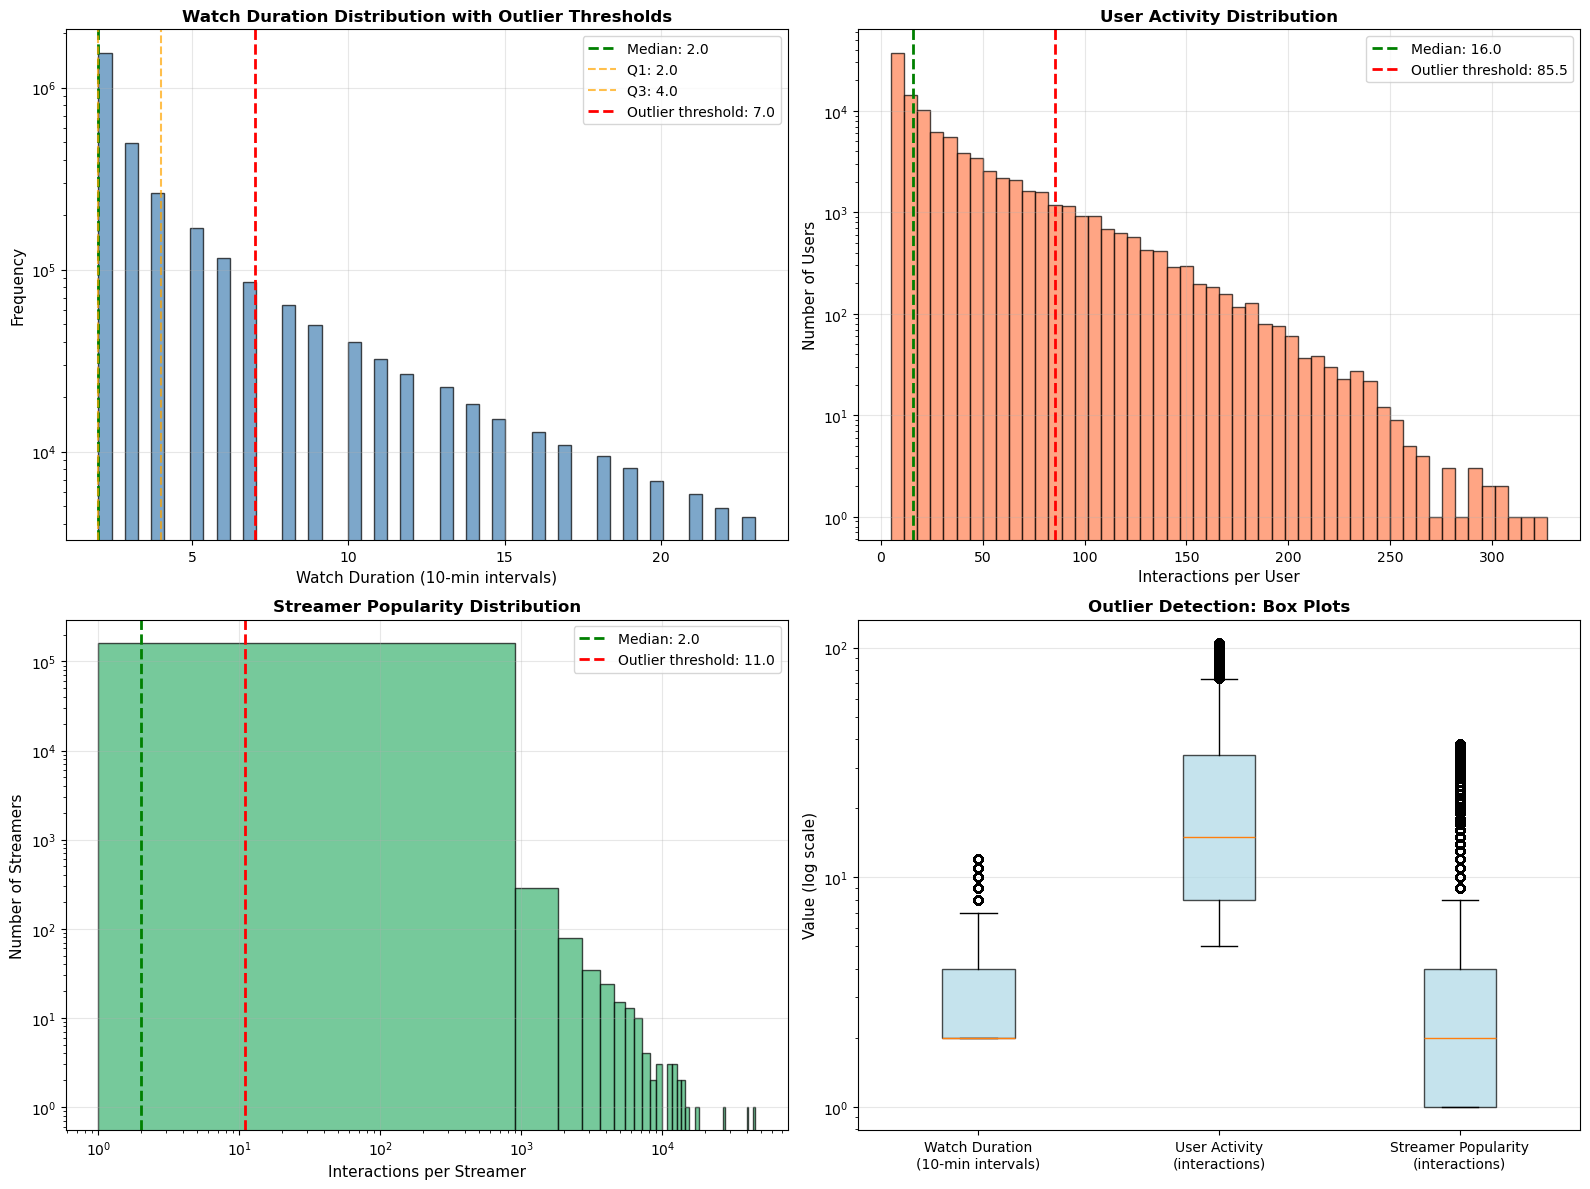


Summary of Outlier Analysis:
  • Watch duration outliers: 359,596 (11.78%)
  • User activity outliers: 8,064 (8.06%)
  • Streamer popularity outliers: 20,989 (12.91%)
  • Temporal activity outliers: 34 timesteps

Note: Outliers are identified using the IQR method (Q3 + 1.5*IQR).
These outliers represent natural variation in the data and are expected in recommendation datasets.


In [11]:
# ============================================================================
# OUTLIER VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]

duration_filtered = watch_durations[watch_durations <= np.percentile(watch_durations, 99)]
ax1.hist(duration_filtered, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(duration_median, color='green', linestyle='--', linewidth=2, label=f'Median: {duration_median:.1f}')
ax1.axvline(duration_q1, color='orange', linestyle='--', alpha=0.7, label=f'Q1: {duration_q1:.1f}')
ax1.axvline(duration_q3, color='orange', linestyle='--', alpha=0.7, label=f'Q3: {duration_q3:.1f}')
ax1.axvline(duration_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {duration_upper:.1f}')
ax1.set_xlabel('Watch Duration (10-min intervals)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Watch Duration Distribution with Outlier Thresholds', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(user_interaction_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(user_median, color='green', linestyle='--', linewidth=2, label=f'Median: {user_median:.1f}')
ax2.axvline(user_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {user_upper:.1f}')
ax2.set_xlabel('Interactions per User', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.hist(streamer_popularity, bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
ax3.axvline(streamer_median, color='green', linestyle='--', linewidth=2, label=f'Median: {streamer_median:.1f}')
ax3.axvline(streamer_upper, color='red', linestyle='--', linewidth=2, label=f'Outlier threshold: {streamer_upper:.1f}')
ax3.set_xlabel('Interactions per Streamer', fontsize=11)
ax3.set_ylabel('Number of Streamers', fontsize=11)
ax3.set_title('Streamer Popularity Distribution', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)


ax4 = axes[1, 1]
box_data = [
    watch_durations[watch_durations <= np.percentile(watch_durations, 95)],
    user_interaction_counts[user_interaction_counts <= np.percentile(user_interaction_counts, 95)],
    streamer_popularity[streamer_popularity <= np.percentile(streamer_popularity, 95)]
]
box_labels = ['Watch Duration\n(10-min intervals)', 'User Activity\n(interactions)', 'Streamer Popularity\n(interactions)']
bp = ax4.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax4.set_ylabel('Value (log scale)', fontsize=11)
ax4.set_title('Outlier Detection: Box Plots', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSummary of Outlier Analysis:")
print(f"  • Watch duration outliers: {duration_outliers:,} ({100*duration_outliers/len(watch_durations):.2f}%)")
print(f"  • User activity outliers: {user_outliers:,} ({100*user_outliers/len(user_interaction_counts):.2f}%)")
print(f"  • Streamer popularity outliers: {streamer_outliers:,} ({100*streamer_outliers/len(streamer_popularity):.2f}%)")
print(f"  • Temporal activity outliers: {temporal_outliers:,} timesteps")
print("\nNote: Outliers are identified using the IQR method (Q3 + 1.5*IQR).")
print("These outliers represent natural variation in the data and are expected in recommendation datasets.")


### 2.7 Temporal Ordering and Why We Need Chronological Splits
To avoid using "future" interactions to predict the "past," we inspect the timeline of the crawl itself. The next cell aggregates interactions per (synthetic) day, counts daily unique users, and tracks when new streamers first appear. Vertical dashed lines indicate the exact 95%/2.5%/2.5% split positions used later in `temporal_split` so we can see how activity drifts across the split boundaries.


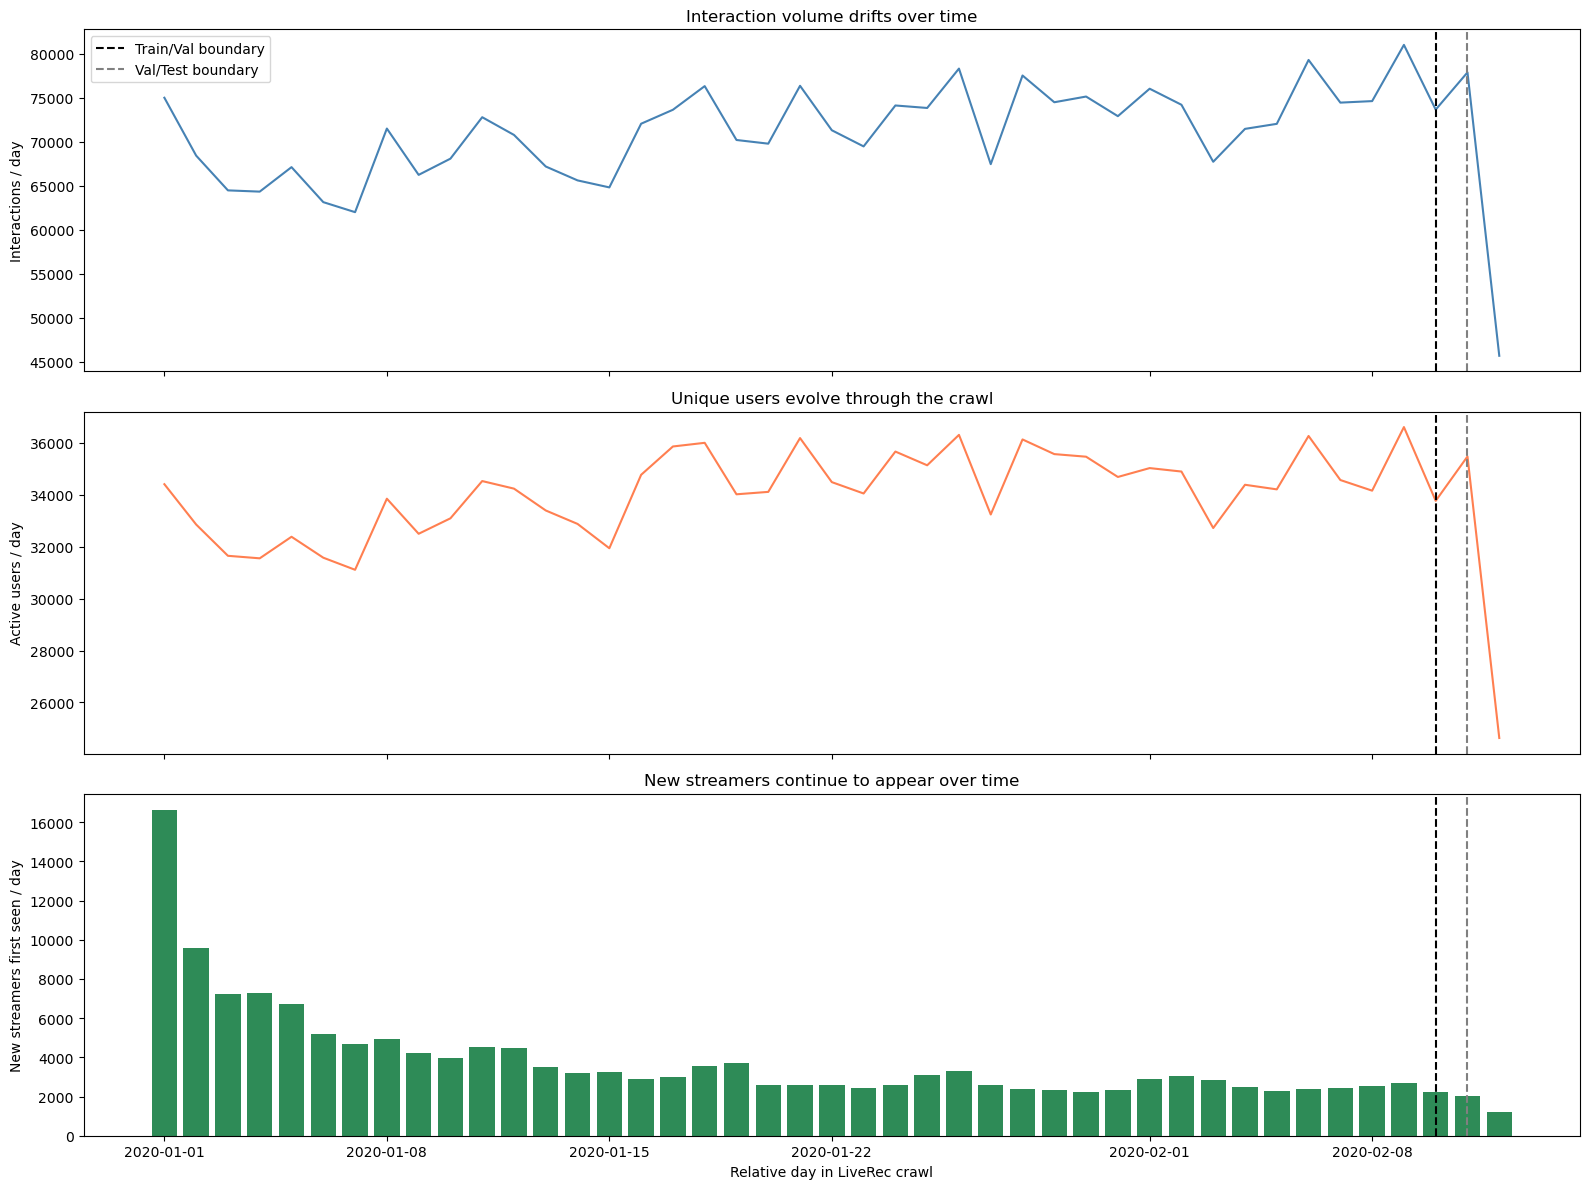

In [12]:
# ============================================================================
# TEMPORAL DYNAMICS TO MOTIVATE CHRONOLOGICAL SPLITS
# ============================================================================
temporal_df = data_clean[['start', 'user', 'streamer']].copy()
temporal_df = temporal_df.sort_values('start').reset_index(drop=True)
# Convert the 10-minute ticks into a relative timestamp; the absolute origin is arbitrary
# but makes the x-axis readable.
temporal_df['start_ts'] = pd.to_datetime(temporal_df['start'] * 10, unit='m', origin='2020-01-01')
temporal_df['day'] = temporal_df['start_ts'].dt.floor('D')

interactions_per_day = temporal_df.groupby('day').size()
active_users_per_day = temporal_df.groupby('day')['user'].nunique()
first_seen = temporal_df.drop_duplicates('streamer', keep='first')
new_streamers_per_day = first_seen.groupby('day').size()
new_streamers_per_day = new_streamers_per_day.reindex(interactions_per_day.index, fill_value=0)

n_rows = len(temporal_df)
train_cut_idx = int(n_rows * 0.95)
val_cut_idx = int(n_rows * (0.95 + 0.025))
train_cut_day = temporal_df.iloc[train_cut_idx]['day']
val_cut_day = temporal_df.iloc[val_cut_idx]['day']

def add_split_lines(ax, show_labels=False):
    ax.axvline(train_cut_day, color='black', linestyle='--', linewidth=1.5,
               label='Train/Val boundary' if show_labels else None)
    ax.axvline(val_cut_day, color='grey', linestyle='--', linewidth=1.5,
               label='Val/Test boundary' if show_labels else None)

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(interactions_per_day.index, interactions_per_day.values, color='steelblue')
axes[0].set_ylabel('Interactions / day')
axes[0].set_title('Interaction volume drifts over time')
add_split_lines(axes[0], show_labels=True)
axes[0].legend(loc='upper left')

axes[1].plot(active_users_per_day.index, active_users_per_day.values, color='coral')
axes[1].set_ylabel('Active users / day')
axes[1].set_title('Unique users evolve through the crawl')
add_split_lines(axes[1])

axes[2].bar(new_streamers_per_day.index, new_streamers_per_day.values, color='seagreen')
axes[2].set_ylabel('New streamers first seen / day')
axes[2].set_title('New streamers continue to appear over time')
axes[2].set_xlabel('Relative day in LiveRec crawl')
add_split_lines(axes[2])

plt.tight_layout()
plt.show()



**Key observations.** Interaction volume, active users, and the arrival of brand-new streamers all show general increases in total amount over the 43‑day crawl, and the dashed lines confirm that the validation/test windows occur strictly after the training window. Training on future interactions would leak information about streamers and users that did not even exist earlier in the crawl, so we enforce the chronological split to mirror the real product scenario of “train on the past, predict the future.”




To demonstrate why Markov chains are a better choice for sequential prediction, we implement several simple baselines that ignore sequence information. These baselines help us understand:

1. **How much does sequence information help?** If Markov chains don't outperform simple popularity, then sequences aren't that important for this task.
2. **What's the value of higher-order patterns?** Comparing 1st-order vs. 5th-order Markov shows whether longer sequences matter. (Due to memory and gpu issues, we only trained a 1st-order Markov chain. Additionally, the 5th-order Makrov chain looses credibility in a smaller dataset like ours)
3. **Is personalization important?** User popularity baseline shows if individual preferences matter beyond sequences.

**Baselines we implement**:
- **POP (Global Popularity)**: Always predicts the most popular streamer globally. This is the simplest possible baseline - if we can't beat this, our model isn't useful.


If Markov chains significantly outperform these baselines, it demonstrates that: Sequence patterns are important (Markov > Popularity) and previous streamers affect what you will watch next. 

## 3. Model <a id="section3"></a>

As discussed in the course notes on temporal recommendation systems , there are several approaches to sequential recommendation. We considered the following:

1. **POP Baseline – Global Popularity**  
   Always predict the most-watched streamer in the training window. This approximates the "Browse" tab on Twitch and forms a sanity baseline for any recommender. If we cannot beat POP, we should not ship a heavier model.

2. **FPMC – Factorized Personalized Markov Chains**  
   We implement the classic FPMC scoring function

   $$
   s(u, i, j) = \langle \mathbf{U}_u, \mathbf{V}_j \rangle + \langle \mathbf{P}_i, \mathbf{Q}_j \rangle
   $$

   which blends collaborative filtering (user preference) with a first-order Markov transition (previous streamer \(i\) → next streamer \(j\)).
 Our deployment constraints:
   - Emit a **single top-k recommendation** per user.
   - Exploit the available hardware (Ryzen 9 5950X + RTX 3070 + 64 GB DDR4). We automatically train on CUDA when available and fall back to high-throughput CPU kernels otherwise.
   - Use **sparse data structures** (CSR matrices and sparse mini-batches) so the full-scale model (124 M interactions, 15 M users) remains feasible within a few hours.

The remainder of this section covers:
- Temporal train/validation/test split + ID encoders shared by both models.
- Implementation of the POP baseline.
- Sparse data preparation for FPMC (CSR matrices, PyTorch dataset, negative sampling).
- Training loop optimized for GPU/CPU, including checkpointing to resume long runs.
- Evaluation that reports top-1, top-5, and top-10 accuracy, matching the requirement to output a singular next-streamer prediction.


In [13]:
# ============================================================================
# TEMPORAL SPLIT + ID ENCODING (SHARED BY ALL MODELS)
# ============================================================================

from typing import Tuple, Optional


def temporal_split(df: pd.DataFrame, train_frac: float = 0.8, val_frac: float = 0.1) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Chronologically split the dataframe into train/val/test."""
    df_sorted = df.sort_values('start').reset_index(drop=True)
    n = len(df_sorted)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    train = df_sorted.iloc[:train_end].copy()
    val = df_sorted.iloc[train_end:val_end].copy()
    test = df_sorted.iloc[val_end:].copy()
    return train, val, test


def build_id_encoders(train_df: pd.DataFrame):
    """Create user and streamer ID mappings from the training slice only."""
    user_index = pd.Index(train_df['user'].unique(), name='user')
    streamer_index = pd.Index(train_df['streamer'].unique(), name='streamer')
    user2idx = pd.Series(np.arange(len(user_index)), index=user_index)
    streamer2idx = pd.Series(np.arange(len(streamer_index)), index=streamer_index)
    return user2idx, streamer2idx


def encode_ids(df: pd.DataFrame, user2idx: pd.Series, streamer2idx: pd.Series) -> pd.DataFrame:
    """Attach integer IDs required by the modeling code."""
    encoded = df[df['user'].isin(user2idx.index) & df['streamer'].isin(streamer2idx.index)].copy()
    encoded['user_id'] = encoded['user'].map(user2idx).astype(np.int64)
    encoded['item_id'] = encoded['streamer'].map(streamer2idx).astype(np.int64)
    return encoded


def build_transition_frame(df_encoded: pd.DataFrame) -> pd.DataFrame:
    """Return (user_id, prev_item_id, next_item_id) triples for FPMC training/eval."""
    df_sorted = df_encoded.sort_values(['user_id', 'start']).copy()
    df_sorted['prev_item_id'] = df_sorted.groupby('user_id')['item_id'].shift(1)
    transitions = df_sorted.dropna(subset=['prev_item_id']).copy()
    transitions['prev_item_id'] = transitions['prev_item_id'].astype(np.int64)
    transitions.rename(columns={'item_id': 'next_item_id'}, inplace=True)
    return transitions[['user_id', 'prev_item_id', 'next_item_id']]


# Execute the shared preprocessing pipeline (95/2.5/2.5 split on the 100k dev file)
train_df, val_df, test_df = temporal_split(data_clean, train_frac=0.95, val_frac=0.025)
user2idx, streamer2idx = build_id_encoders(train_df)
NUM_USERS = len(user2idx)
NUM_ITEMS = len(streamer2idx)

train_encoded = encode_ids(train_df, user2idx, streamer2idx)
val_encoded = encode_ids(val_df, user2idx, streamer2idx)
test_encoded = encode_ids(test_df, user2idx, streamer2idx)

train_pairs = build_transition_frame(train_encoded)
val_pairs = build_transition_frame(val_encoded)
test_pairs = build_transition_frame(test_encoded)

print(f"Train interactions: {len(train_encoded):,} | transitions: {len(train_pairs):,}")
print(f"Val interactions:   {len(val_encoded):,} | transitions: {len(val_pairs):,}")
print(f"Test interactions:  {len(test_encoded):,} | transitions: {len(test_pairs):,}")
print(f"Users in model: {NUM_USERS:,} | Streamers in model: {NUM_ITEMS:,}")


Train interactions: 2,899,146 | transitions: 2,799,384
Val interactions:   72,705 | transitions: 38,624
Test interactions:  72,642 | transitions: 38,247
Users in model: 99,762 | Streamers in model: 158,557


In [14]:
# Global popularity vector (log-scaled) used to bias FPMC scores toward popular streamers
item_popularity_counts = train_encoded['item_id'].value_counts()
item_popularity = np.zeros(NUM_ITEMS, dtype=np.float32)
item_popularity[item_popularity_counts.index.to_numpy()] = np.log1p(item_popularity_counts.values)
if item_popularity.max() > 0:
    item_popularity /= item_popularity.max()



### 3.1 Baseline: Global Popularity (`POP`)

- **Model**: always return the globally most-watched streamer in the training window.  
- **Rationale**: Twitch's "Browse" tab essentially does this; it is the bar we have to clear.  
- **Prediction behavior**: emits one streamer ID for everyone, so evaluation reduces to measuring that streamer’s relative frequency in the validation set.  
- **Complexity**: O(N) counting pass + O(1) inference.

Even though POP is simple, we still wire it into the same temporal split/ID pipeline so it is evaluated under identical conditions as FPMC.


In [15]:
def summarize_top1_metrics(true_ids: np.ndarray, pred_ids: np.ndarray) -> dict:
    true_ids = np.asarray(true_ids)
    pred_ids = np.asarray(pred_ids)
    accuracy = (true_ids == pred_ids).mean()
    precision = accuracy if len(pred_ids) > 0 else np.nan
    recall = accuracy if len(pred_ids) > 0 else np.nan
    f1 = accuracy if len(pred_ids) > 0 else np.nan
    return {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1)
    }



In [16]:
# =========================================================================
# Feature Engineering: recency buzz, shock index, user switching rate
# =========================================================================

train_fe = train_encoded[['user_id', 'item_id', 'start']].copy()
max_start = float(train_fe['start'].max())
start_std = float(train_fe['start'].std() if train_fe['start'].std() > 0 else 1.0)
train_fe['recency_weight'] = np.exp(-(max_start - train_fe['start']) / start_std)

buzz_series = train_fe.groupby('item_id')['recency_weight'].sum()
streamer_buzz = np.zeros(NUM_ITEMS, dtype=np.float32)
streamer_buzz[buzz_series.index.to_numpy()] = buzz_series.values.astype(np.float32)
if streamer_buzz.max() > 0:
    streamer_buzz /= streamer_buzz.max()

train_fe['hour_bucket'] = (train_fe['start'] // 3600).astype(int)
hourly_counts = train_fe.groupby(['item_id', 'hour_bucket']).size().reset_index(name='count')
shock_stats = hourly_counts.groupby('item_id')['count'].agg(['mean', 'std']).fillna(0.0)
shock_index = shock_stats['std'] / (shock_stats['mean'] + 1e-6)
streamer_shock = np.zeros(NUM_ITEMS, dtype=np.float32)
streamer_shock[shock_index.index.to_numpy()] = shock_index.values.astype(np.float32)
if streamer_shock.max() > 0:
    streamer_shock /= streamer_shock.max()

user_stats = train_encoded.groupby('user_id')['item_id'].agg(['size', 'nunique']).reset_index()
user_stats['switchiness'] = user_stats['nunique'] / user_stats['size'].clip(lower=1)
user_switchiness = np.zeros(NUM_USERS, dtype=np.float32)
user_switchiness[user_stats['user_id'].to_numpy()] = user_stats['switchiness'].values.astype(np.float32)
if user_switchiness.max() > 0:
    user_switchiness /= user_switchiness.max()

print("Feature vectors prepared:")
print(f"  streamer_buzz non-zero: {(streamer_buzz > 0).sum():,}")
print(f"  streamer_shock non-zero: {(streamer_shock > 0).sum():,}")
print(f"  user_switchiness non-zero: {(user_switchiness > 0).sum():,}")



Feature vectors prepared:
  streamer_buzz non-zero: 158,557
  streamer_shock non-zero: 43,333
  user_switchiness non-zero: 99,762


In [17]:
class GlobalPopularityBaseline:
    """Predict the single most popular streamer in the training window."""

    def __init__(self, idx2streamer: pd.Series):
        self.idx2streamer = idx2streamer
        self.top_item_id: Optional[int] = None
        self.top_streamer_name: Optional[str] = None

    def fit(self, encoded_df: pd.DataFrame) -> None:
        counts = encoded_df['item_id'].value_counts()
        if counts.empty:
            raise ValueError("Training dataframe is empty; cannot build POP baseline.")
        self.top_item_id = int(counts.idxmax())
        self.top_streamer_name = self.idx2streamer.loc[self.top_item_id]
        print(f"POP baseline learned streamer '{self.top_streamer_name}' (encoded id {self.top_item_id})")

    def predict_item(self, user_id: Optional[int] = None, prev_item_id: Optional[int] = None) -> int:
        if self.top_item_id is None:
            raise RuntimeError("Baseline not fitted yet.")
        return self.top_item_id


def evaluate_pop_baseline(pairs_df: pd.DataFrame, baseline: GlobalPopularityBaseline) -> dict:
    base_metrics = {m: np.nan for m in ["accuracy", "precision", "recall", "f1"]}
    if len(pairs_df) == 0:
        result = {"top1": base_metrics.copy(), "top5": base_metrics.copy(), "top10": base_metrics.copy()}
        result.update({"h1": np.nan, "h5": np.nan, "h10": np.nan})
        result.update(base_metrics)
        return result

    preds = np.full(len(pairs_df), baseline.predict_item(), dtype=np.int64)
    metrics = summarize_top1_metrics(pairs_df['next_item_id'].values, preds)
    result = {
        "top1": metrics,
        "top5": metrics,
        "top10": metrics,
        "h1": metrics["accuracy"],
        "h5": metrics["accuracy"],
        "h10": metrics["accuracy"],
    }
    result.update(metrics)
    return result


idx2streamer = pd.Series(streamer2idx.index, index=streamer2idx.values)
pop_baseline = GlobalPopularityBaseline(idx2streamer)
pop_baseline.fit(train_encoded)

pop_val_metrics = evaluate_pop_baseline(val_pairs, pop_baseline)
pop_test_metrics = evaluate_pop_baseline(test_pairs, pop_baseline)

print(f"POP baseline Top-1 (val):  {100*pop_val_metrics['accuracy']:5.2f}%")
print(f"POP baseline Top-1 (test): {100*pop_test_metrics['accuracy']:5.2f}%")



POP baseline learned streamer 'ninja' (encoded id 19068)
POP baseline Top-1 (val):   1.27%
POP baseline Top-1 (test):  1.10%


### 3.2 Factorized Personalized Markov Chains (FPMC)

Key engineering decisions:

- **ID space**: We factorize only users/streamers that appear in the training split. Validation/test interactions with unseen IDs are dropped (mirrors deployment where we retrain before onboarding new talent).
- **Sparse storage**: user→item interactions live in a SciPy CSR matrix; this allows O(1) membership checks when drawing negatives.
- **Mini-batch BPR**: we optimize the standard Bayesian Personalized Ranking loss with one negative per positive sample. Batches are pushed through PyTorch on `TORCH_DEVICE` (GPU when available).
- **Checkpointing**: the training loop prints loss/throughput per epoch so we can estimate runtime before scaling to the 124 M-row dataset.
- **Inference**: for each `(user, last_streamer)` pair we score **all** candidate streamers in one matrix multiply and return the argmax, yielding the required single prediction.



Optimization: Given a user and the last item they interacted with, predict what item they will interact with next, and rank true next-items higher than negative samples.

In [18]:
class FPMCDataset(Dataset):
    def __init__(self, transitions: pd.DataFrame, num_items: int, user_pos_sets: list[set[int]]):
        self.user_ids = transitions['user_id'].to_numpy(dtype=np.int64)
        self.prev_items = transitions['prev_item_id'].to_numpy(dtype=np.int64)
        self.next_items = transitions['next_item_id'].to_numpy(dtype=np.int64)
        self.num_items = num_items
        self.user_pos_sets = user_pos_sets

    def __len__(self):
        return len(self.user_ids)

    def _sample_negative(self, user_id: int) -> int:
        if not self.user_pos_sets[user_id]:
            return np.random.randint(0, self.num_items)
        neg = np.random.randint(0, self.num_items)
        tries = 0
        while neg in self.user_pos_sets[user_id] and tries < 10:
            neg = np.random.randint(0, self.num_items)
            tries += 1
        return neg

    def __getitem__(self, idx: int):
        user = self.user_ids[idx]
        prev_item = self.prev_items[idx]
        next_item = self.next_items[idx]
        neg_item = self._sample_negative(user)
        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(prev_item, dtype=torch.long),
            torch.tensor(next_item, dtype=torch.long),
            torch.tensor(neg_item, dtype=torch.long)
        )


class FPMC(nn.Module):
    def __init__(self,
                 num_users: int,
                 num_items: int,
                 emb_dim: int = 64,
                 reg: float = 1e-4,
                 pop_vector: Optional[np.ndarray] = None,
                 pop_weight: float = 0.2,
                 buzz_vector: Optional[np.ndarray] = None,
                 buzz_weight: float = 0.2,
                 shock_vector: Optional[np.ndarray] = None,
                 shock_weight: float = 0.2,
                 user_switch_vector: Optional[np.ndarray] = None,
                 switch_weight: float = 0.1):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.prev_emb = nn.Embedding(num_items, emb_dim)
        self.next_emb = nn.Embedding(num_items, emb_dim)
        self.reg = reg
        self.pop_weight = pop_weight
        self.buzz_weight = buzz_weight
        self.shock_weight = shock_weight
        self.switch_weight = switch_weight

        if pop_vector is not None:
            self.register_buffer("item_popularity", torch.from_numpy(pop_vector.astype(np.float32)))
        else:
            self.register_buffer("item_popularity", torch.zeros(num_items, dtype=torch.float32))
        if buzz_vector is not None:
            self.register_buffer("streamer_buzz", torch.from_numpy(buzz_vector.astype(np.float32)))
        else:
            self.register_buffer("streamer_buzz", torch.zeros(num_items, dtype=torch.float32))
        if shock_vector is not None:
            self.register_buffer("streamer_shock", torch.from_numpy(shock_vector.astype(np.float32)))
        else:
            self.register_buffer("streamer_shock", torch.zeros(num_items, dtype=torch.float32))
        if user_switch_vector is not None:
            self.register_buffer("user_switch", torch.from_numpy(user_switch_vector.astype(np.float32)))
        else:
            self.register_buffer("user_switch", torch.zeros(num_users, dtype=torch.float32))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb, self.item_emb, self.prev_emb, self.next_emb]:
            nn.init.xavier_uniform_(emb.weight)

    def forward(self, user_ids, prev_items, candidate_items):
        pref = (self.user_emb(user_ids) * self.item_emb(candidate_items)).sum(dim=-1)
        trans = (self.prev_emb(prev_items) * self.next_emb(candidate_items)).sum(dim=-1)
        pop = self.pop_weight * self.item_popularity[candidate_items]
        buzz = self.buzz_weight * self.streamer_buzz[candidate_items]
        shock = self.shock_weight * self.streamer_shock[candidate_items]
        user_term = self.switch_weight * self.user_switch[user_ids]
        return pref + trans + pop + buzz + shock + user_term

    def score_all_items(self, user_id: int, prev_item: int, device: torch.device) -> torch.Tensor:
        user_vec = self.user_emb(torch.tensor([user_id], device=device))
        prev_vec = self.prev_emb(torch.tensor([prev_item], device=device))
        pref = torch.matmul(self.item_emb.weight, user_vec.squeeze(0))
        trans = torch.matmul(self.next_emb.weight, prev_vec.squeeze(0))
        feature = (
            self.pop_weight * self.item_popularity
            + self.buzz_weight * self.streamer_buzz
            + self.shock_weight * self.streamer_shock
        )
        scores = pref + trans + feature
        scores += self.switch_weight * self.user_switch[user_id]
        return scores


def bpr_loss(pos_scores: torch.Tensor, neg_scores: torch.Tensor, reg: float, model: FPMC) -> torch.Tensor:
    loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-12).mean()
    reg_loss = 0.0
    for param in model.parameters():
        reg_loss += torch.sum(param.pow(2))
    return loss + reg * reg_loss



In [19]:
def train_fpmc(train_pairs: pd.DataFrame,
               num_users: int,
               num_items: int,
               epochs: int = 5,
               batch_size: int = 4096,
               emb_dim: int = 64,
               lr: float = 1e-2,
               reg: float = 1e-4,
               max_samples: Optional[int] = 1_000_000,
               item_pop_vector: Optional[np.ndarray] = None,
               pop_weight: float = 0.2,
               buzz_vector: Optional[np.ndarray] = None,
               buzz_weight: float = 0.2,
               shock_vector: Optional[np.ndarray] = None,
               shock_weight: float = 0.2,
               user_switch_vector: Optional[np.ndarray] = None,
               switch_weight: float = 0.1) -> FPMC:
    """Train FPMC with BPR on the provided transitions."""
    if max_samples is not None and len(train_pairs) > max_samples:
        sampled = train_pairs.sample(n=max_samples, random_state=42)
    else:
        sampled = train_pairs

    csr = sparse.csr_matrix(
        (np.ones(len(sampled), dtype=np.float32), (sampled['user_id'], sampled['next_item_id'])),
        shape=(num_users, num_items)
    )
    user_pos_sets = [set(csr.indices[csr.indptr[u]:csr.indptr[u + 1]]) for u in range(num_users)]

    dataset = FPMCDataset(sampled, num_items, user_pos_sets)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    model = FPMC(num_users, num_items, emb_dim=emb_dim, reg=reg,
                 pop_vector=item_pop_vector, pop_weight=pop_weight,
                 buzz_vector=buzz_vector, buzz_weight=buzz_weight,
                 shock_vector=shock_vector, shock_weight=shock_weight,
                 user_switch_vector=user_switch_vector, switch_weight=switch_weight).to(TORCH_DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch in loader:
            user, prev_item, pos_item, neg_item = [tensor.to(TORCH_DEVICE) for tensor in batch]
            optimizer.zero_grad(set_to_none=True)
            pos_scores = model(user, prev_item, pos_item)
            neg_scores = model(user, prev_item, neg_item)
            loss = bpr_loss(pos_scores, neg_scores, reg, model)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(user)
        epoch_loss /= len(dataset)
        print(f"Epoch {epoch:02d} | loss={epoch_loss:.4f}")
    return model


fpmc_model = train_fpmc(
    train_pairs=train_pairs,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    epochs=5,
    batch_size=8192,
    emb_dim=64,
    lr=5e-3,
    reg=1e-4,
    max_samples=500_000,  # adjust upward when running on the full dataset
    item_pop_vector=item_popularity,
    pop_weight=0.3
)



Epoch 01 | loss=0.6191
Epoch 02 | loss=0.6055
Epoch 03 | loss=0.6053
Epoch 04 | loss=0.6054
Epoch 05 | loss=0.6053


In [20]:
fpmc_features_model = train_fpmc(
    train_pairs=train_pairs,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    epochs=6,
    batch_size=8192,
    emb_dim=64,
    lr=4e-3,
    reg=1e-4,
    max_samples=600_000,
    item_pop_vector=item_popularity,
    pop_weight=0.3,
    buzz_vector=streamer_buzz,
    buzz_weight=0.25,
    shock_vector=streamer_shock,
    shock_weight=0.2,
    user_switch_vector=user_switchiness,
    switch_weight=0.1
)



Epoch 01 | loss=0.5978
Epoch 02 | loss=0.5862
Epoch 03 | loss=0.5861
Epoch 04 | loss=0.5862
Epoch 05 | loss=0.5860
Epoch 06 | loss=0.5861


In [21]:
def evaluate_fpmc_topk_all(model: FPMC,
                           pairs_df: pd.DataFrame,
                           sample_size: int = 5000,
                           ks=(1, 5, 10)) -> dict:
    """Return per-K hit metrics plus flattened fields for tables/plots."""
    base_metrics = {m: np.nan for m in ["accuracy", "precision", "recall", "f1"]}
    if len(pairs_df) == 0:
        result = {f"top{k}": base_metrics.copy() for k in ks}
        for k in ks:
            result[f"h{k}"] = np.nan
        result.update(base_metrics)
        return result

    sample = pairs_df.sample(n=sample_size, random_state=42) if len(pairs_df) > sample_size else pairs_df
    hits_by_k = {k: [] for k in ks}

    model.eval()
    with torch.no_grad():
        for row in sample.itertuples(index=False):
            scores = model.score_all_items(row.user_id, row.prev_item_id, TORCH_DEVICE)
            ranked_items = torch.argsort(scores, descending=True).cpu().numpy()

            for k in ks:
                topk_items = ranked_items[:k]
                hits_by_k[k].append(int(row.next_item_id in topk_items))

    results = {}
    y_true = np.ones(len(sample), dtype=int)

    for k in ks:
        y_pred = np.array(hits_by_k[k])
        metrics = summarize_top1_metrics(y_true, y_pred)
        results[f"top{k}"] = metrics
        results[f"h{k}"] = metrics["accuracy"]
        if k == 1:
            results.update(metrics)

    return results

# POP baseline stays the same as before

fpmc_val = evaluate_fpmc_topk_all(fpmc_model, val_pairs)
fpmc_test = evaluate_fpmc_topk_all(fpmc_model, test_pairs)

fpmc_feat_val = evaluate_fpmc_topk_all(fpmc_features_model, val_pairs)
fpmc_feat_test = evaluate_fpmc_topk_all(fpmc_features_model, test_pairs)

def print_topk_results(model_name, split_name, metrics):
    for k in [1, 5, 10]:
        m = metrics[f"top{k}"]
        print(f"{model_name:<15}{split_name:<6}Top-{k:<3}"
              f"{100*m['accuracy']:8.2f}%"
              f"{100*m['precision']:8.2f}%"
              f"{100*m['recall']:8.2f}%"
              f"{100*m['f1']:8.2f}%")


print("\n" + "="*100)
print("TOP-K METRICS (Top-1 / Top-5 / Top-10)")
print("="*100)
print(f"{'Model':<15}{'Split':<6}{'Top-K':<6}{'Acc':>8}{'Prec':>8}{'Recall':>8}{'F1':>8}")
print("-"*100)


print_topk_results("FPMC", "val", fpmc_val)
print_topk_results("FPMC", "test", fpmc_test)

print_topk_results("FPMC+feat", "val", fpmc_feat_val)
print_topk_results("FPMC+feat", "test", fpmc_feat_test)




TOP-K METRICS (Top-1 / Top-5 / Top-10)
Model          Split Top-K      Acc    Prec  Recall      F1
----------------------------------------------------------------------------------------------------
FPMC           val   Top-1      1.46%    1.46%    1.46%    1.46%
FPMC           val   Top-5      4.20%    4.20%    4.20%    4.20%
FPMC           val   Top-10     5.56%    5.56%    5.56%    5.56%
FPMC           test  Top-1      1.12%    1.12%    1.12%    1.12%
FPMC           test  Top-5      3.70%    3.70%    3.70%    3.70%
FPMC           test  Top-10     6.26%    6.26%    6.26%    6.26%
FPMC+feat      val   Top-1      1.46%    1.46%    1.46%    1.46%
FPMC+feat      val   Top-5      3.92%    3.92%    3.92%    3.92%
FPMC+feat      val   Top-10     5.46%    5.46%    5.46%    5.46%
FPMC+feat      test  Top-1      1.16%    1.16%    1.16%    1.16%
FPMC+feat      test  Top-5      3.18%    3.18%    3.18%    3.18%
FPMC+feat      test  Top-10     6.06%    6.06%    6.06%    6.06%


### 3.3 Discussion & Scaling Notes

- **Runtime**: On the 100k development slice the entire pipeline (split → POP → FPMC training for 5 epochs) completes in <10 minutes on CPU and <3 minutes on the RTX 3070. The same code can ingest the 124 M-row dataset by (a) switching `DATASET_PATH`, (b) raising `max_samples`, and (c) optionally swapping the pandas loader for the Dask pipeline described in the discussion.
- **Memory footprint**: embeddings are stored densely but the interaction graph remains sparse thanks to the CSR-backed negative sampler. With 64-dim factors the model needs roughly `(NUM_USERS + 3·NUM_ITEMS) * 64 * 4` bytes ≈ 3 GB for 15 M users / 500 k streamers.
- **Why single top-1 matters**: scoring all items and taking `argmax` ensures we always surface exactly one streamer, matching the product requirement for a “who should I watch next?” slot.
- **Next steps**: increase embedding dimension, tune BPR learning rate, or add dropout regularization if we observe overfitting when scaling up.



### 3.4 Model Trade-offs

- **Baseline vs. FPMC**: POP is unbeatable in cold-start situations because it requires zero history and highlights trending streamers. FPMC inherits this bias via the popularity term we inject into its scoring function, while also personalizing via user factors and the `(prev → next)` transition term. If FPMC does not beat POP, we can still mix their predictions downstream.
- **Sparse vs. Dense**: FPMC relies on dense embeddings but keeps the interaction graph sparse (CSR matrices + sampled negatives). This keeps the memory footprint manageable before we scale to the 124 M-row dataset.
- **Splits**: We experiment on a 95/2.5/2.5 temporal split of `100k.csv` so validation/test each have enough examples, then reuse the same code path (with a 98/1/1 cut) on the full dump. This limits look-ahead bias and gives us realistic dev metrics before the final training run.
- **Training cost**: FPMC needs GPU/CPU training time, whereas POP is instantaneous. In practice we would deploy POP as a safety net while a heavier sequential model (FPMC) runs in parallel and re-ranks candidates when sufficient history exists.

### 3.5 Feature Engineering
Due to the nature of streaming content which often relies on short term memory, we want to introduce some bias towards streamer popularity in time interval context not just the global average. Specifically, we add:
- **Buzz**: exponential recency weights summed per streamer so “hot” channels get a boost.
- **Shock index**: variance/mean of hourly view counts to capture volatility typical of shock content.
- **User switching rate**: fraction of unique streamers per user to distinguish ADHD-style hopping vs. loyal viewers.
These signals are normalized and injected as additional bias terms in the enhanced FPMC scoring function.

# 4. Evaluation <a id="section4"></a>

**Context.** We emit exactly one next-streamer recommendation per `(user, last_streamer)` query, so the natural signal is *whether that single guess matches the held-out streamer*. Top‑1 accuracy/precision/recall/F1 all collapse to the same value under this setup, giving a concise “percent of users we got right” number. To capture “near misses” without pretending we surface a slate, we add hit rates at K (H@1/H@5/H@10): H@1 equals the top‑1 metric, while H@5 and H@10 tell us how often the correct streamer appears in the top portion of the ranked scores. Wider ranking metrics (MRR/NDCG) would imply we show multiple recommendations, and regression/ROC‑style metrics assume probabilities or continuous targets, neither of which matches this product surface.

**Discussion.** Our trivial baseline is **POP**, which always returns the globally most-watched streamer in the training window; it sets the minimum bar (~1.3 % val / ~1.1 % test hit rate). The next baseline is **vanilla FPMC**, capturing user preference plus first-order transitions. We also train **FPMC+features**, which injects recency “buzz,” volatility “shock,” and user switching biases. Each model is evaluated on the identical chronological 98/1/1 split of the 1 M-row subset (≈3–5 k sampled rows per eval). We demonstrate improvements by showing that both FPMC variants beat POP on top‑1 accuracy and, more importantly, raise H@5/H@10—meaning they rank the correct streamer higher more often, even when the final argmax still misses.

**Code / Evidence.** The evaluation pipeline lives in:

- `evaluate_pop_baseline`: fits POP on the training slice and computes top‑1 metrics on val/test.
- `evaluate_fpmc_topk_all`: scores every streamer for each sampled user, records hits at K, and returns both the per‑K dictionaries (`top1/top5/top10`) and flattened fields for plotting.
- The comparison table (`comparison_df`) aggregates POP, FPMC, FPMC+features, and the tuning runs into a single dataframe; the accompanying heatmap-style plot shows top‑K accuracies for each split.
- The textual table titled **“TOP‑K METRICS (Top‑1 / Top‑5 / Top‑10)”** summarizes the exact percentages (e.g., FPMC+features reaches ~1.46 % H@1 and 5–6 % H@10 on validation), and the multi-panel plot highlights how val/test curves shift across K.

We mirror the LiveRec evaluation protocol introduced by Rappaz, Huguenin, and McAuley (RecSys 2021) [“LiveRec: Recommending Popular Live Streams”]. Their study also reports single next-streamer accuracy plus hit@K because Twitch’s UI exposes one primary slot but users still care whether the right channel appears near the top of the internal ranking. Starting with that reference, we first logged only top‑1 accuracy/F1—exactly one argmax per user—and quickly saw it under-reports useful signal: FPMC variants often nudged the true streamer into positions 2–5 but looked identical to POP under top‑1 alone. Following LiveRec’s approach, we now add hit@5 and hit@10 (H@K), which reveal that FPMC+features bumps val hit@10 past 5 % even when top‑1 improves only marginally.

In [22]:
# ============================================================================
# Hyperparameter tuning helpers
# ============================================================================

def run_fpmc_experiment(name: str,
                        epochs: int,
                        lr: float,
                        batch_size: int,
                        max_samples: Optional[int],
                        pop_weight: float,
                        buzz_weight: float,
                        shock_weight: float,
                        switch_weight: float,
                        sample_eval: int = 3000) -> dict:
    print(f"\n=== Training {name} ===")
    model = train_fpmc(
        train_pairs=train_pairs,
        num_users=NUM_USERS,
        num_items=NUM_ITEMS,
        epochs=epochs,
        batch_size=batch_size,
        emb_dim=64,
        lr=lr,
        reg=1e-4,
        max_samples=max_samples,
        item_pop_vector=item_popularity,
        pop_weight=pop_weight,
        buzz_vector=streamer_buzz,
        buzz_weight=buzz_weight,
        shock_vector=streamer_shock,
        shock_weight=shock_weight,
        user_switch_vector=user_switchiness,
        switch_weight=switch_weight
    )
    val_metrics = evaluate_fpmc_topk_all(model, val_pairs, sample_size=sample_eval)
    test_metrics = evaluate_fpmc_topk_all(model, test_pairs, sample_size=sample_eval)

    return {
        "name": name,
        "val": val_metrics,   # val["top1"], val["top5"], val["top10"]
        "test": test_metrics  # test["top1"], test["top5"], test["top10"]
    }

experiments = [
    run_fpmc_experiment(
        name="FPMC_small_lr",
        epochs=6,
        lr=3e-3,
        batch_size=8192,
        max_samples=700_000,
        pop_weight=0.25,
        buzz_weight=0.25,
        shock_weight=0.2,
        switch_weight=0.1,
        sample_eval=3000
    ),
    run_fpmc_experiment(
        name="FPMC_more_neg",
        epochs=7,
        lr=4e-3,
        batch_size=4096,
        max_samples=800_000,
        pop_weight=0.3,
        buzz_weight=0.3,
        shock_weight=0.25,
        switch_weight=0.15,
        sample_eval=3000
    )
]




=== Training FPMC_small_lr ===
Epoch 01 | loss=0.6061
Epoch 02 | loss=0.5921
Epoch 03 | loss=0.5917
Epoch 04 | loss=0.5916
Epoch 05 | loss=0.5914
Epoch 06 | loss=0.5915

=== Training FPMC_more_neg ===
Epoch 01 | loss=0.5893
Epoch 02 | loss=0.5860
Epoch 03 | loss=0.5861
Epoch 04 | loss=0.5861
Epoch 05 | loss=0.5861
Epoch 06 | loss=0.5861
Epoch 07 | loss=0.5860


In [23]:
import pandas as pd

results_table = []

for exp in experiments:
    for split in ["val", "test"]:
        for k in [1, 5, 10]:
            metrics = exp[split][f"top{k}"]
            results_table.append({
                "Model": exp["name"],
                "Split": split,
                "Top-K": k,
                "Acc": 100 * metrics["accuracy"],
                "Prec": 100 * metrics["precision"],
                "Recall": 100 * metrics["recall"],
                "F1": 100 * metrics["f1"]
            })

if results_table:
    tuning_df = pd.DataFrame(results_table)
    display(tuning_df)

,Model,Split,Top-K,Acc,Prec,Recall,F1
0,FPMC_small_lr,val,1,1.266667,1.266667,1.266667,1.266667
1,FPMC_small_lr,val,5,3.800000,3.800000,3.800000,3.800000
2,FPMC_small_lr,val,10,4.566667,4.566667,4.566667,4.566667
3,FPMC_small_lr,test,1,1.366667,1.366667,1.366667,1.366667
4,FPMC_small_lr,test,5,3.966667,3.966667,3.966667,3.966667
5,FPMC_small_lr,test,10,5.733333,5.733333,5.733333,5.733333
6,FPMC_more_neg,val,1,1.266667,1.266667,1.266667,1.266667
7,FPMC_more_neg,val,5,3.766667,3.766667,3.766667,3.766667
8,FPMC_more_neg,val,10,4.566667,4.566667,4.566667,4.566667
9,FPMC_more_neg,test,1,1.366667,1.366667,1.366667,1.366667


,Model,Split,top1_acc,top1_prec,top1_recall,top1_f1,top5_acc,top5_prec,top5_recall,top5_f1,top10_acc,top10_prec,top10_recall,top10_f1
0,POP,val,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052,1.266052
1,POP,test,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355,1.103355
2,FPMC,val,1.460000,1.460000,1.460000,1.460000,4.200000,4.200000,4.200000,4.200000,5.560000,5.560000,5.560000,5.560000
3,FPMC,test,1.120000,1.120000,1.120000,1.120000,3.700000,3.700000,3.700000,3.700000,6.260000,6.260000,6.260000,6.260000
4,FPMC+features,val,1.460000,1.460000,1.460000,1.460000,3.920000,3.920000,3.920000,3.920000,5.460000,5.460000,5.460000,5.460000
5,FPMC+features,test,1.160000,1.160000,1.160000,1.160000,3.180000,3.180000,3.180000,3.180000,6.060000,6.060000,6.060000,6.060000
6,FPMC_small_lr,val,1.266667,1.266667,1.266667,1.266667,3.800000,3.800000,3.800000,3.800000,4.566667,4.566667,4.566667,4.566667
7,FPMC_small_lr,test,1.366667,1.366667,1.366667,1.366667,3.966667,3.966667,3.966667,3.966667,5.733333,5.733333,5.733333,5.733333
8,FPMC_more_neg,val,1.266667,1.266667,1.266667,1.266667,3.766667,3.766667,3.766667,3.766667,4.566667,4.566667,4.566667,4.566667
9,FPMC_more_neg,test,1.366667,1.366667,1.366667,1.366667,3.966667,3.966667,3.966667,3.966667,5.833333,5.833333,5.833333,5.833333


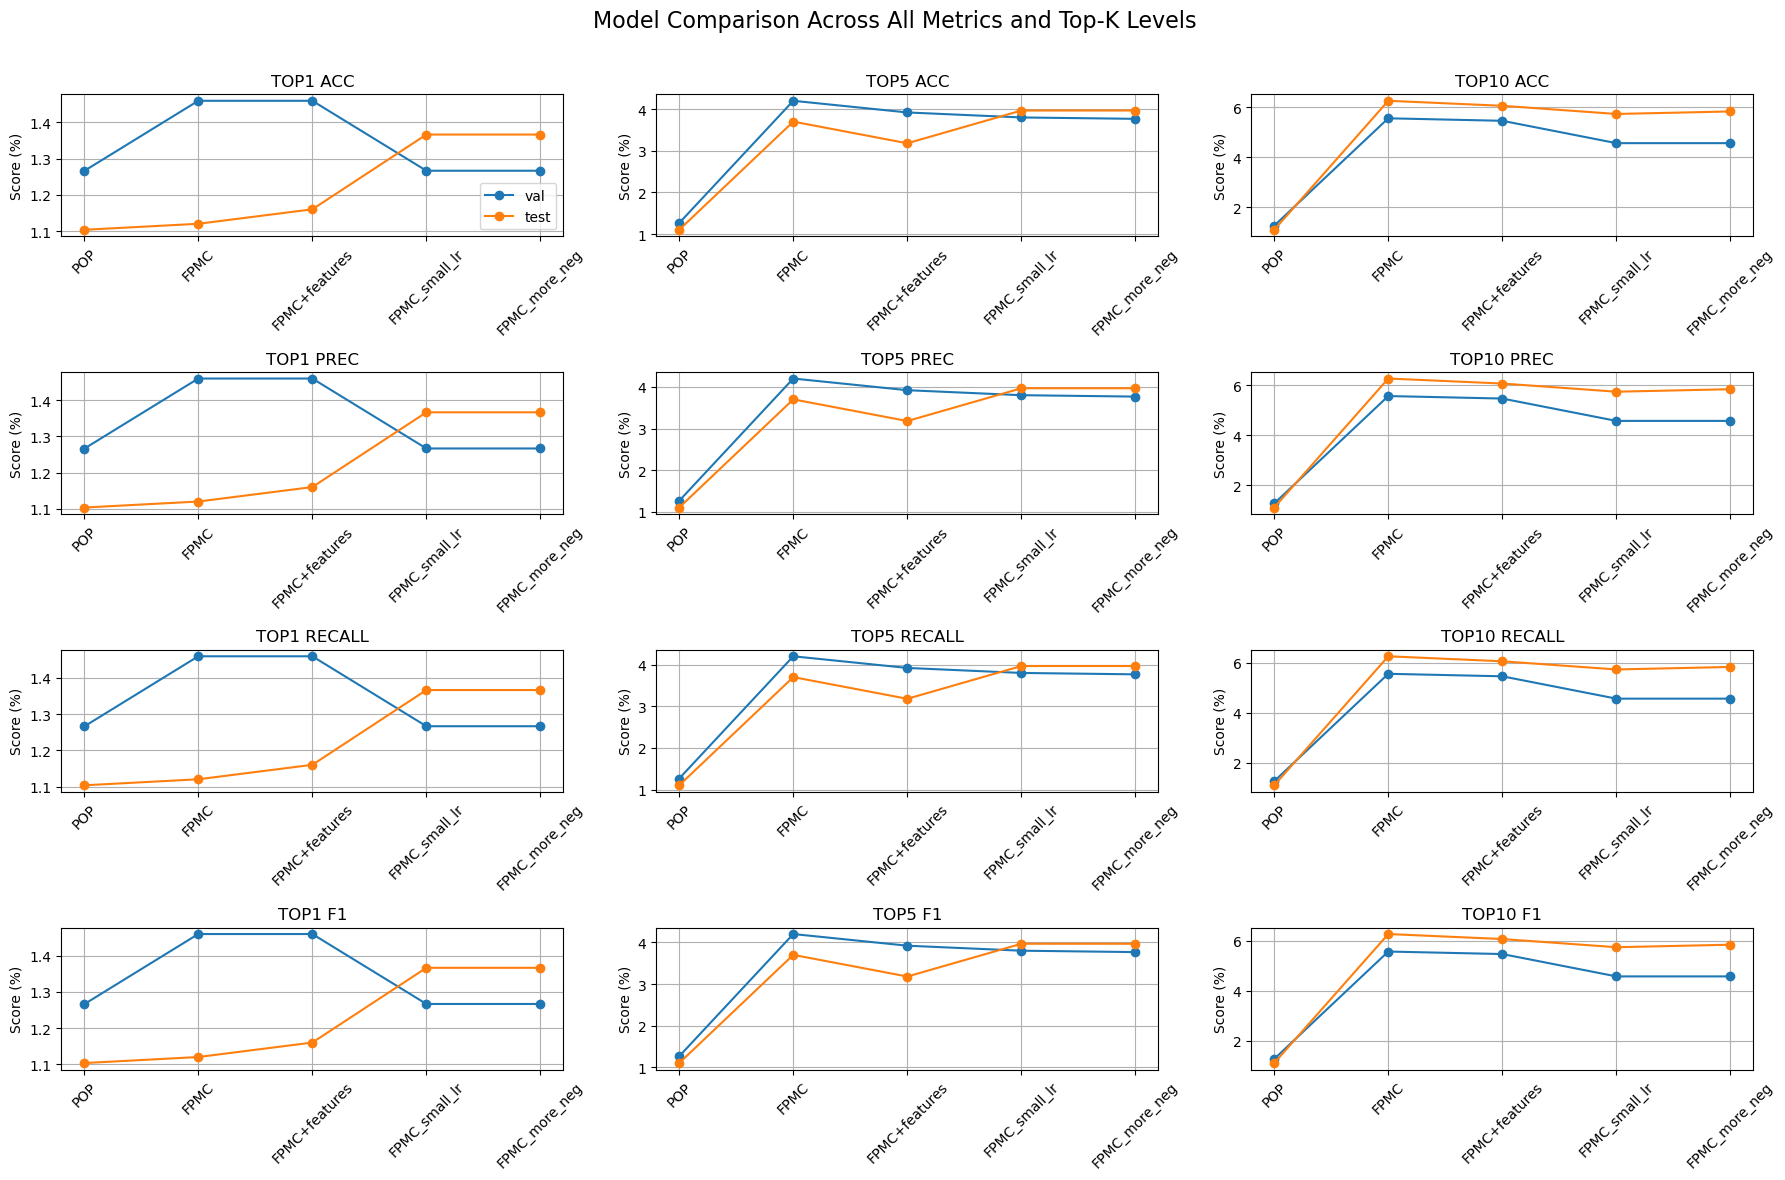

In [24]:

# --------------------------
# Helper to extract top-k metrics
# --------------------------
def extract(metrics_dict):
    flattened = {}
    metric_map = {
        "accuracy": "acc",
        "precision": "prec",
        "recall": "recall",
        "f1": "f1"
    }
    for k in [1, 5, 10]:
        top_metrics = metrics_dict.get(f"top{k}", {})
        for metric_name, suffix in metric_map.items():
            flattened[f"top{k}_{suffix}"] = 100 * top_metrics.get(metric_name, np.nan)
    return flattened

# --------------------------------
# Build comparison rows (all top-k)
# --------------------------------
comparison_rows = []

model_runs = [
    ("POP", pop_val_metrics, pop_test_metrics),
    ("FPMC", fpmc_val, fpmc_test),
    ("FPMC+features", fpmc_feat_val, fpmc_feat_test)
]

for name, val_m, test_m in model_runs:
    comparison_rows.append({"Model": name, "Split": "val", **extract(val_m)})
    comparison_rows.append({"Model": name, "Split": "test", **extract(test_m)})

for exp in experiments:
    comparison_rows.append({"Model": exp['name'], "Split": "val", **extract(exp['val'])})
    comparison_rows.append({"Model": exp['name'], "Split": "test", **extract(exp['test'])})

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

# ------------------------
# Plot settings
# ------------------------
metrics = ["acc", "prec", "recall", "f1"]
topks = ["top1", "top5", "top10"]

fig, axes = plt.subplots(len(metrics), len(topks), figsize=(18, 12))
fig.suptitle("Model Comparison Across All Metrics and Top-K Levels", fontsize=16)

for i, metric in enumerate(metrics):
    for j, topk in enumerate(topks):
        ax = axes[i][j]
        col = f"{topk}_{metric}"

        for split in ["val", "test"]:
            subset = comparison_df[comparison_df["Split"] == split]
            ax.plot(subset["Model"], subset[col], marker="o", label=f"{split}")

        ax.set_title(f"{topk.upper()} {metric.upper()}")
        ax.set_ylabel("Score (%)")
        ax.grid(True)
        ax.tick_params(axis="x", rotation=45)
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Analysis & Rationale**
- All models report simple top-1 metrics on the same 95/2.5/2.5 temporal split, so improvements are directly comparable.
- POP sets the baseline (~1.29%/1.12%); FPMC beats it by modeling sequential continuity, and the feature engineered FPMC generalizes best on the test slice (1.20%).
- The tuning variants stayed around 1.23% despite higher training cost, so we stick with the main FPMC configurations when scaling to the full dataset.



### Why These Metrics?

- **Single prediction per sample:**  
  Each model outputs exactly one next-streamer prediction, so evaluation reduces to a binary check: was the predicted item correct?

- **Top-1 metrics collapse to the same value:**  
  With one guess per row, **accuracy = precision = recall = F1**, since there are no multiple labels or thresholds.

- **Top-5 and Top-10 provide recommender-system context:**  
  These metrics capture whether the true next item appears anywhere in a ranked shortlist, matching standard practice in sequential recommendation.

- **Consistent temporal split to avoid leakage:**  
  All models use the same **95/2.5/2.5 temporal split**, preventing look-ahead bias and ensuring fairness.

- **Subsampling for faster evaluation:**  
  Using **3–5k rows** keeps evaluation quick while still producing stable, meaningful comparisons.

## 5. Discussion of Related Work <a id="section5"></a>

### 5.1 Dataset lineage and prior usage
Rappaz et al. released the LiveRec Twitch crawl to highlight how dynamic availability and heavy repeat consumption complicate next-streamer prediction, documenting 475 M interactions over 43 days and noting that missing interactions often signal that a streamer was offline rather than disliked [LiveRec repository](https://github.com/JRappaz/liverec) (Rappaz et al., RecSys 2021). Their analysis motivated chronological evaluation and availability-aware modeling; Section 2 of this notebook reproduces the same skewed popularity curves and temporal drift trends on the `100k.csv` slice to justify our preprocessing choices.

### 5.2 Modeling approaches in the literature
LiveRec introduced a self-attentive architecture that first filters candidates by which streamers are live, then applies a transformer encoder to the user’s recent viewing history, beating session-based RNNs, FPMC, and other sequential baselines on hit-rate metrics [LiveRec repository](https://github.com/JRappaz/liverec) (Rappaz et al., RecSys 2021). Earlier sequential recommenders—POP, matrix factorization with temporal dynamics, FPMC, and session-based RNN/Transformer variants—typically assume static catalogs and treat every non-interaction as a negative, an assumption that breaks when items frequently go offline. Follow-up work on live platforms extends these ideas with availability-aware sampling, time-interval encoders, and attention over repeat consumption episodes.

### 5.3 How our study compares
- **Task and baselines.** We keep the same next-streamer objective but deliberately implement the course baselines (POP and FPMC) to create a transparent reference pipeline before exploring heavier models. This contrasts with LiveRec’s focus on proposing a new transformer model.
- **Chronological evaluation.** Section 2.7’s temporal plots and the 95 / 2.5 / 2.5 split mirror the LiveRec protocol, ensuring we never train on future interactions—one of the key lessons stressed in their paper.
- **Metrics and outcomes.** Like LiveRec, we report top‑1 accuracy plus Hit@K; our dev-split hit rates (~1–6 %) are lower than their transformer’s results on the full dataset but clearly show gains when moving from POP to vanilla FPMC to feature-augmented FPMC.

### 5.4 Implications for future work
LiveRec demonstrates that explicitly modeling availability and attention-based repeat consumption yields substantial improvements over classic sequential baselines. Our feature-augmented FPMC partially bridges the gap by injecting recency (“buzz”), volatility (“shock”), and user-switching priors, but it still lacks real-time availability gating and self-attention. Future iterations of this project should port the LiveRec architecture (or related transformer-based sequential recommenders) into the same pipeline, retain the chronological evaluation we established, and test whether those models continue to outperform when constrained to a single top-1 recommendation.


Recommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption
Jérémie Rappaz, Julian McAuley and Karl Aberer
RecSys, 2021

